In [1]:
import sys, os, json, copy, sklearn, shap, gc, joblib, copy, time, ast
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from rdsutils.woe import WOE_Transform                                            
from rdsutils.metrics import get_pred_reports
from sqlalchemy import create_engine

import mdsutils

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

print(lgb.__version__)

3.2.1


In [2]:
config_path = "s3://sofi-data-science/hpeng/pl-gen4/artifact/config.json"
with open(os.path.join(config_path), "r") as f:
    config = json.load(f)

In [3]:
model_member = pkl.load(open('../../models/'+'member'+'_final.pkl', 'rb'))
model_non_member = pkl.load(open('../../models/'+'non_member'+'_final.pkl', 'rb'))
model_non_member29 = pkl.load(open('../../models/'+'non_member'+'_final_29.pkl', 'rb')) # refitted model
model_prescreen = pkl.load(open('../../models/'+'prescreen'+'_final.pkl', 'rb'))

Trying to unpickle estimator LabelEncoder from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [4]:
feature_list = model_prescreen.feature_name_ + model_member.feature_name_ + model_non_member.feature_name_  \
            + config["data_columns"]["benchmark_cols"] + \
            config["data_columns"]["meta_cols"] + ['all_time_lending_member_flag'] + ['income_update']
feature_list = pd.unique(feature_list).tolist()

In [5]:
base_list = ['all_time_lending_member_flag',
 'all_time_months_oldest_pl_trade',
 'applicant_fico_score',
 'applicant_type',
 'applicant_vantage_score',
 'current_pl_trade_bal_ratio',
 'date_start',
 'id',
 'income_update']
pre_list = [
    'loan_info',
    'applicant_type',
    'p13_all2919',
 'p13_all5320',
 'p13_all7110',
 'p13_all7312',
 'p13_all7518',
 'p13_all7519',
 'p13_all7936',
 'p13_all8352',
 'p13_all8800',
 'p13_aut8140',
 'p13_bca7600',
 'p13_bca8370',
 'p13_bcc5227',
 'p13_bcc5520',
 'p13_bcc7580',
 'p13_bcc8322',
 'p13_bcx7110',
 'p13_brc7150',
 'p13_cru1300',
 'p13_cru8320',
 'p13_iln8222',
 'p13_iqb9740',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9420',
 'p13_iqz9425',
 'p13_iqz9426',
 'p13_iqz9427',
 'p13_mtf8111',
 'p13_pil8320',
 'p13_reh7120',
 'p13_rta7300',
 'p13_rtr5520',
 'p13_upl0438',
 'p13_upl8132',
 'p13_upl8320',
 'p13_all5840',
 'p13_mtf5838']
pre_list2 = [
    'id',
    'applicant_type',
    'p13_all2919',
 'p13_all5320',
 'p13_all7110',
 'p13_all7312',
 'p13_all7518',
 'p13_all7519',
 'p13_all7936',
 'p13_all8352',
 'p13_all8800',
 'p13_aut8140',
 'p13_bca7600',
 'p13_bca8370',
 'p13_bcc5227',
 'p13_bcc5520',
 'p13_bcc7580',
 'p13_bcc8322',
 'p13_bcx7110',
 'p13_brc7150',
 'p13_cru1300',
 'p13_cru8320',
 'p13_iln8222',
 'p13_iqb9740',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9420',
 'p13_iqz9425',
 'p13_iqz9426',
 'p13_iqz9427',
 'p13_mtf8111',
 'p13_pil8320',
 'p13_reh7120',
 'p13_rta7300',
 'p13_rtr5520',
 'p13_upl0438',
 'p13_upl8132',
 'p13_upl8320',
 'p13_all5840',
 'p13_mtf5838']
trend_list = [    'id',
    'applicant_type',
't11_tall02q3',
 't11_tall0722',
 't11_tall2205',
 't11_tall3205',
 't11_tbca2303',
 't11_tbca2381',
 't11_tbca2526',
 't11_tbca2530',
 't11_tbca3243',
 't11_tbca3530',
 't11_tbca4504',
 't11_tbcc1303',
 't11_tbcc2267',
 't11_tbcc3305',
 't11_tbcc4208',
 't11_tbcc4355',
 't11_tiln0727',
 't11_tiln2754',
 't11_tiln2755',
 't11_tmti02q7',
 't11_tmti2752',
 't11_tpil01q1',
 't11_trev0722',
 't11_tstu1752',
 't11_tstu2752',
 't11_tupl01q1']
trade_list = ['id','applicant_type','sofi_num_month_recent_list_psl']
inq_list = [ 'id','applicant_type','sofi_num_inq_12month',
 'sofi_num_inq_1month',
 'sofi_num_inq_3month',
 'sofi_num_inq_personal_finance']

### save Athena data to S3

In [6]:
def ath_to_s3(table_name_in,condition,table_name_out):
    start=time.time()
    ath = mdsutils.AthenaClient()
    
    query = """select 
    * 
    from pl_gen4_model.{0} {1}"""
    
    df=ath.query_to_df(query.format(table_name_in,condition))   
    
    output = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/{}.parquet'.format(table_name_out)
    data_location = f'{output}'
    df.to_parquet(data_location)
    
    run_time=round((time.time()-start)/60,1)
    print('run_time: {0} mins'.format(run_time))
    del df
    gc.collect()

In [7]:
#ath_to_s3('trended_3d_v1_1_pre_2022','','trended_3d_v1_1_pre_22')

In [8]:
# ath_to_s3('trended_3d_v1_1_pre_2021','','trended_3d_v1_1_pre_21_2')

In [9]:
# ath_to_s3('premier_v13_pre_21','','premier_v13_pre_21')

In [10]:
# ath_to_s3('premier_v13_pre_22','','premier_v13_pre_22')

In [11]:
try: 
    df_income = pd.read_csv("../../data/income_each_3.csv")
except:
    from sqlalchemy import create_engine

    def getSQL_product(sql, u = "", p = ""):
        db_string = "postgres://" + u + ":" + p + "@localhost:15551/sofi_product"
        #conn = sql.connect(database='sofidw', host='dw.sofi.com', user=username, password=password)
        #df = pd.read_sql_query(s, con=conn, coerce_float = False)
        #conn.close()
        db = create_engine(db_string)
        df = pd.read_sql_query(sql,con=db)
        return df

    sql_prod = """SELECT op.target_id as id,
           debtor_type            as applicant_type,
           gross_income           as income_each
    FROM offer_package op
             join underwriting_packet up on op.uw_packet_id = up.id
             join underwriting_data ud on ud.uw_packet_id = up.id
    WHERE op.id IN
          (SELECT max(op2.id)
           FROM offer_package op1
                    JOIN offer_package op2
                         ON op1.target_id = op2.target_id AND op2.target_type = 'APP' and op1.target_type = 'APP'
                         -- and   op1.target_id IN ('1790172')
           GROUP BY op1.target_id)
      and debtor_type in ('PRIMARY','COBORROWER')
      and product_name = 'PL'
      and op.created_dt>='2021-01-01'
    ORDER BY op.target_id;"""

    df_income = getSQL_product(sql_prod)

### 2021Q1-202201
#### internal base data
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/pl_gen4_Experian_input_2021_v1.csv
#### premier:
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/premier_v13_pre_21.parquet
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/premier_v13_pre_22.parquet
#### trended 
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/trended_3d_v1_1_pre_21_2.parquet
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/trended_3d_v1_1_pre_22.parquet
#### inquiry
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/feature_creation/agg_inquiry_attr_2021Q1_202201.parquet    
#### trade
    s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/feature_creation/agg_trade_attr_2021Q1_202201.parquet
#### member data

In [13]:
def getSQL_dw(sql, u = "", p = ""):
    db_string = "postgres://" + u + ":" + p + "@localhost:15494/sofi_dw"
    #conn = sql.connect(database='sofidw', host='dw.sofi.com', user=username, password=password)
    #df = pd.read_sql_query(s, con=conn, coerce_float = False)
    #conn.close()
    db = create_engine(db_string)
    df = pd.read_sql_query(sql,con=db)
    return df

In [14]:
try:
    df_base = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/df_base_21.parquet')
except:
    query="""
    select af.dw_applicant_id,
           af.id,
           af.applicant_type,
           af.fraud_status,
           af.fraudulent,
           af.applied_city,
           af.applied_state,
           af.applied_cbsa_name,
           af.applied_cbsa_code,
           af.credit_score,
           af.fico,
           af.vantage,
           af.initial_decision,
           af.current_decision,
           af.housing_status,
           af.date_start,
           af.time_start,
           af.date_fund,
           af.fraud_outcome,
           af.current_activity,
           af.consolidated_channel,
           af.coborrower_indicator,
           af.status_string,
           af.last_status_date,
           af.confirmed_fraud,
           af.charge_off_date,
           af.charge_off_prin,
           af.applicant_fico_score,
           af.applicant_vantage_score,
           af.requested_amount,
           af.pl_funds_use,
           af.gross_income,
           af.member_indicator,
           af.applied_zip,
           af.age,
           af.first,
           af.last,
           af.deceased,
           af.deceased_date,
           af.is_approved,
           af.is_funded,
           af.ever30dpd6m_flag,
           af.ever60dpd6m_flag,
           af.ever30dpd12m_flag,
           af.ever60dpd12m_flag,
           af.ever30dpd18m_flag,
           af.ever60dpd18m_flag,
           af.ever90dpd18m_flag,
           af.ever30dpd24m_flag,
           af.ever60dpd24m_flag,
           af.ever90dpd24m_flag,
           af.everbk6m_flag,
           af.everbk12m_flag,
           af.everbk18m_flag,
           af.everbk24m_flag,
           af.everforb6m_flag,
           af.everforb12m_flag,
           af.everforb18m_flag,
           af.everforb24m_flag,
           af.device,
           coalesce(m.all_time_pl_member_flag, 0)      as all_time_pl_member_flag,
           coalesce(m.all_time_slr_member_flag, 0)     as all_time_slr_member_flag,
           coalesce(m.all_time_isl_member_flag, 0)     as all_time_isl_member_flag,
           coalesce(m.all_time_lending_member_flag, 0) as all_time_lending_member_flag,
           m.all_time_months_oldest_lending_trade,
           m.all_time_months_newest_lending_trade,
           m.all_time_months_oldest_pl_trade,
           m.all_time_months_newest_pl_trade,
           coalesce(m.all_time_num_lending_trade, 0)   as all_time_num_lending_trade,
           coalesce(m.all_time_num_pl_trade, 0)        as all_time_num_pl_trade,
           coalesce(m.current_num_lending_trade, 0)    as current_num_lending_trade,
           coalesce(m.current_num_pl_trade, 0)         as current_num_pl_trade,
           m.all_time_lending_trade_orig_bal,
           m.all_time_pl_trade_orig_bal,
           m.current_lending_trade_orig_bal,
           m.current_pl_trade_orig_bal,
           m.current_lending_trade_current_prin,
           m.current_pl_trade_current_prin,
           m.current_lending_trade_bal_ratio,
           m.current_pl_trade_bal_ratio,
           m.all_time_avg_pl_term,
           m.all_time_avg_sl_term,
           m.current_avg_pl_term,
           m.current_avg_sl_term,
           m.all_time_num_lending_trade_ever30dpd3m,
           m.all_time_num_lending_trade_ever60dpd3m,
           m.all_time_num_lending_trade_ever90dpd3m,
           m.all_time_num_lending_trade_ever30dpd6m,
           m.all_time_num_lending_trade_ever60dpd6m,
           m.all_time_num_lending_trade_ever90dpd6m,
           m.all_time_num_lending_trade_ever30dpd12m,
           m.all_time_num_lending_trade_ever60dpd12m,
           m.all_time_num_lending_trade_ever90dpd12m,
           m.all_time_num_lending_trade_ever30dpd24m,
           m.all_time_num_lending_trade_ever60dpd24m,
           m.all_time_num_lending_trade_ever90dpd24m,
           m.all_time_num_lending_trade_current_30dpd,
           m.all_time_num_lending_trade_current_60dpd,
           m.all_time_num_lending_trade_current_forb,
           m.all_time_num_lending_trade_everforb24m,
           m.all_time_num_lending_trade_paidinfull,
           m.all_time_num_pl_trade_ever30dpd3m,
           m.all_time_num_pl_trade_ever60dpd3m,
           m.all_time_num_pl_trade_ever90dpd3m,
           m.all_time_num_pl_trade_ever30dpd6m,
           m.all_time_num_pl_trade_ever60dpd6m,
           m.all_time_num_pl_trade_ever90dpd6m,
           m.all_time_num_pl_trade_ever30dpd12m,
           m.all_time_num_pl_trade_ever60dpd12m,
           m.all_time_num_pl_trade_ever90dpd12m,
           m.all_time_num_pl_trade_ever30dpd24m,
           m.all_time_num_pl_trade_ever60dpd24m,
           m.all_time_num_pl_trade_ever90dpd24m,
           m.all_time_num_pl_trade_current_30dpd,
           m.all_time_num_pl_trade_current_60dpd,
           m.all_time_num_pl_trade_current_forb,
           m.all_time_num_pl_trade_everforb24m,
           m.all_time_num_pl_trade_paidinfull
    from dwanalyst.pl_gen4_base_202202 af
             left join dwanalyst.pl_gen4_member_agg_202202 m
                       on af.id = m.current_id and af.dw_applicant_id = m.dw_applicant_id;

    """
    # base df
    df_base=getSQL_dw(query)

    df_base['date_start'] = pd.to_datetime(df_base['date_start'])
    df_base.shape

    df_base.to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/df_base_21.parquet')

In [15]:
df_p21 = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/premier_v13_pre_21.parquet', columns = pre_list)
df_p22 = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/premier_v13_pre_22.parquet', columns = pre_list2)
df_p = pd.concat([df_p21,df_p22], axis=0, ignore_index=True)

In [16]:
df_p['id'] = np.where(df_p.id.isnull(), df_p.loan_info, df_p.id)
df_p['id'] = pd.to_numeric(df_p.id)

In [17]:
df = pd.merge(df_base, df_p, how = 'left', left_on=['id', 'applicant_type'], right_on = ['id','applicant_type'])
df.shape

(2154635, 157)

In [18]:
df_tr21 = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/trended_3d_v1_1_pre_21_2.parquet', columns = trend_list)
df_tr22 = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/trended_3d_v1_1_pre_22.parquet', columns = trend_list)
df_tr = pd.concat([df_tr21,df_tr22], axis=0, ignore_index=True)

In [19]:
df = pd.merge(df, df_tr, how = 'left', left_on=['id', 'applicant_type'], right_on = ['id','applicant_type'])
df.shape

(2154635, 183)

In [20]:
df_inq = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/feature_creation/agg_inquiry_attr_2021Q1_202201.parquet', columns = inq_list)
df_inq ['id'] = df_inq['id'].astype(int)
df = pd.merge(df, df_inq, how = 'left', left_on=['id', 'applicant_type'], right_on = ['id','applicant_type'])
df.shape

(2154635, 187)

In [21]:
df_trade = pd.read_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/raw_tables/feature_creation/agg_trade_attr_2021Q1_202201.parquet', columns = trade_list)
df_trade ['id'] = df_trade['id'].astype(int)
df = pd.merge(df, df_trade, how = 'left', left_on=['id', 'applicant_type'], right_on = ['id','applicant_type'])
df.shape

(2154635, 188)

In [22]:
df = pd.merge(df, df_income, on =['id','applicant_type'], how = 'left')
display(df.shape)

(2154635, 190)

In [23]:
# cap income each at gross_income
df['income_each'] = np.where(df['income_each']>df['gross_income'], df['gross_income'], df['income_each'])
# define income_update as individual income
df['income_update'] = np.where(df.coborrower_indicator == 'N',df['gross_income'], df['income_each'])
df['income_update'] = np.where(df.income_update.isnull(),np.where(df.coborrower_indicator == 'N', df['gross_income'], df['gross_income']/2), df['income_update'])    
# create debt to income
df['sofi_all5840_to_income'] = np.where((df['income_update'].isnull()) | (df['p13_all5840'].isnull()) | (df['income_update'] == 0), np.nan,
                                              np.where(df['p13_all5840']<=999999990, df['p13_all5840']*12/df['income_update'], 0))
df['sofi_mtf5838_to_income'] = np.where((df['income_update'].isnull()) | (df['p13_mtf5838'].isnull()) | (df['income_update'] == 0), np.nan,
                                              np.where(df['p13_mtf5838']<=999999990, df['p13_mtf5838']*12/df['income_update'], 0))
df['sofi_all5840_mtf5838_to_income'] = df['sofi_all5840_to_income'] - df['sofi_mtf5838_to_income']
df['sofi_all5840_mtf5838_to_income'] = np.where(df['sofi_all5840_mtf5838_to_income']<0, 0, df['sofi_all5840_mtf5838_to_income'])

df['sofi_all5840_to_combined_income'] = np.where((df['gross_income'].isnull()) | (df['p13_all5840'].isnull()) | (df['gross_income'] == 0), np.nan,
                                              np.where(df['p13_all5840']<=999999990, df['p13_all5840']*12/df['gross_income'], 0))
df['sofi_mtf5838_to_combined_income'] = np.where((df['gross_income'].isnull()) | (df['p13_mtf5838'].isnull()) | (df['gross_income'] == 0), np.nan,
                                              np.where(df['p13_mtf5838']<=999999990, df['p13_mtf5838']*12/df['gross_income'], 0))
df['sofi_all5840_mtf5838_to_combined_income'] = df['sofi_all5840_to_combined_income'] - df['sofi_mtf5838_to_combined_income']
df['sofi_all5840_mtf5838_to_combined_income'] = np.where(df['sofi_all5840_mtf5838_to_combined_income']<0, 0, df['sofi_all5840_mtf5838_to_combined_income'])

In [24]:
### 8% due to linking service matching issue, 8% not able to pull credit pull xml file
df_ex = df[(~df.t11_tall02q3.isnull()) & (~df.p13_rta7300.isnull()) & (~df.sofi_num_inq_12month.isnull())].copy()
df_ex.id.nunique()/df.id.nunique()

0.8491182528681064

In [25]:
df_ex.isnull().mean()

dw_applicant_id                            0.000000
id                                         0.000000
applicant_type                             0.000000
fraud_status                               0.953631
fraudulent                                 0.000000
                                             ...   
sofi_mtf5838_to_income                     0.079949
sofi_all5840_mtf5838_to_income             0.079949
sofi_all5840_to_combined_income            0.078650
sofi_mtf5838_to_combined_income            0.078650
sofi_all5840_mtf5838_to_combined_income    0.078650
Length: 197, dtype: float64

### scoring

In [26]:
exp_dict = pd.read_csv(config["meta"]["exp_dict_path"])

In [27]:
def categorical_to_nan(series, categorical_list):
    """ given series and a list of catergorical values
    
    replace the categorical occurances to nan
    """
    if len(categorical_list) == 0:
        return series
    mapper = dict((k, np.nan) for k in categorical_list)
    return series.replace(mapper)

no_special_list = []

for col in tqdm(feature_list):
    try:
        special_val = ast.literal_eval(exp_dict[exp_dict.field_name == col].categorical.iloc[0])
        special_val = [int(i) for i in special_val]
        df_ex[col] = categorical_to_nan(df_ex[col], special_val)
    except:
         no_special_list.append(col)
        
len(no_special_list)

100%|██████████| 80/80 [00:01<00:00, 64.08it/s]


22

In [28]:
df_ex['seg'] = 'other'
df_ex.loc[(df_ex.all_time_lending_member_flag==1), 'seg'] = 'member'
df_ex.loc[(df_ex.all_time_lending_member_flag!=1), 'seg'] = 'non_member'

In [29]:
df_oot_full_member_ = df_ex[df_ex.seg=='member'].copy()
df_oot_full_non_member_ = df_ex[df_ex.seg=='non_member'].copy()
df_oot_full_prescreen_ = df_ex.copy()

impute_vals_member = pkl.load(open('../../models/'+'member'+'_final_imputed_val.pkl', 'rb'))
impute_vals_non_member = pkl.load(open('../../models/'+'non_member'+'_final_imputed_val.pkl', 'rb'))
impute_vals_prescreen = pkl.load(open('../../models/'+'prescreen'+'_final_imputed_val.pkl', 'rb'))

for f in tqdm(model_member.feature_name_):
    try:
        val = impute_vals_member[f]
        df_oot_full_member_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)    
        
for f in tqdm(model_non_member.feature_name_):
    try:
        val = impute_vals_non_member[f]
        df_oot_full_non_member_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)
        
for f in tqdm(model_prescreen.feature_name_):
    try:
        val = impute_vals_prescreen[f]
        df_oot_full_prescreen_[f].fillna(val, inplace=True)
    except:
        print("no special value for " + f)

100%|██████████| 31/31 [00:00<00:00, 1221.93it/s]


no special value for p13_iqz9420
no special value for p13_iqz9426
no special value for sofi_num_inq_12month


100%|██████████| 31/31 [00:00<00:00, 196.77it/s]


no special value for p13_iqz9427
no special value for sofi_num_inq_1month
no special value for sofi_num_inq_3month
no special value for sofi_num_inq_personal_finance


 61%|██████▏   | 19/31 [00:00<00:00, 182.40it/s]

no special value for p13_iqz9420
no special value for p13_iqz9425


100%|██████████| 31/31 [00:00<00:00, 156.35it/s]


In [30]:
# df_oot_full_member_.to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_member_psi_21q4.parquet')
# df_oot_full_non_member_.to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_nonmember_psi_21q4.parquet')
# df_oot_full_prescreen_.to_parquet('s3://sofi-data-science/hpeng/pl-gen4/data_dump/data_to_mrm/df_prescreen_psi_21q4.parquet')

In [30]:
df_oot_full_member_['gen4_underwriting_prob'] = model_member.predict_proba(df_oot_full_member_[model_member.feature_name_])[:,1]
df_oot_full_non_member_['gen4_underwriting_prob'] = model_non_member.predict_proba(df_oot_full_non_member_[model_non_member.feature_name_])[:,1]

df_oot_full_member_['gen4_underwriting_prob_29'] = model_member.predict_proba(df_oot_full_member_[model_member.feature_name_])[:,1]
df_oot_full_non_member_['gen4_underwriting_prob_29'] = model_non_member29.predict_proba(df_oot_full_non_member_[model_non_member29.feature_name_])[:,1]

df_oot_ = pd.concat([df_oot_full_member_, df_oot_full_non_member_], axis=0, ignore_index=True)

df_oot_full_prescreen_['gen4_prescreen_prob'] = model_prescreen.predict_proba(df_oot_full_prescreen_[model_prescreen.feature_name_])[:,1]

In [31]:
df_oot_ = pd.merge(df_oot_, df_oot_full_prescreen_[['gen4_prescreen_prob','id','applicant_type','date_start']],
              how = 'inner', on = ['id', 'applicant_type', 'date_start'])

In [32]:
df_oot_.shape

(1799053, 201)

In [33]:
factor = 40/np.log(2)
offset = 650 - factor * np.log(5)

df_oot_['uw_log_odds'] = np.log((1 - df_oot_['gen4_underwriting_prob'])/df_oot_['gen4_underwriting_prob'])
df_oot_['uw_odds'] = ((1 - df_oot_['gen4_underwriting_prob'])/df_oot_['gen4_underwriting_prob'])

df_oot_['gen4_underwriting_score'] = round(offset+factor*df_oot_['uw_log_odds'])
df_oot_.loc[df_oot_.gen4_underwriting_score>850,'gen4_underwriting_score']=850
df_oot_.loc[df_oot_.gen4_underwriting_score<300,'gen4_underwriting_score']=300

df_oot_['uw_log_odds_29'] = np.log((1 - df_oot_['gen4_underwriting_prob_29'])/df_oot_['gen4_underwriting_prob_29'])
df_oot_['uw_odds_29'] = ((1 - df_oot_['gen4_underwriting_prob_29'])/df_oot_['gen4_underwriting_prob_29'])

df_oot_['gen4_underwriting_score_29'] = round(offset+factor*df_oot_['uw_log_odds_29'])
df_oot_.loc[df_oot_.gen4_underwriting_score_29>850,'gen4_underwriting_score_29']=850
df_oot_.loc[df_oot_.gen4_underwriting_score_29<300,'gen4_underwriting_score_29']=300

df_oot_['pr_log_odds'] = np.log((1 - df_oot_['gen4_prescreen_prob'])/df_oot_['gen4_prescreen_prob'])
df_oot_['pr_odds'] = ((1 - df_oot_['gen4_prescreen_prob'])/df_oot_['gen4_prescreen_prob'])

df_oot_['gen4_prescreen_score'] = round(offset+factor*df_oot_['pr_log_odds'])
df_oot_.loc[df_oot_.gen4_prescreen_score>850,'gen4_prescreen_score']=850
df_oot_.loc[df_oot_.gen4_prescreen_score<300,'gen4_prescreen_score']=300

Text(0.5, 1.0, 'Score Distribution')

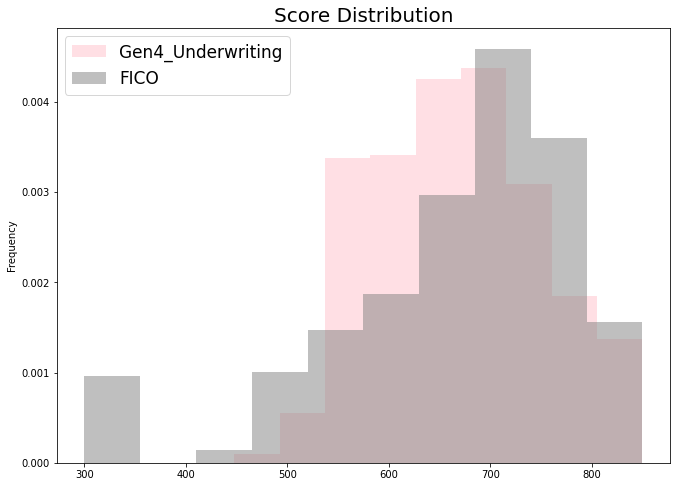

In [34]:
df_oot_['fico_adj'] = np.where(df_oot_.applicant_fico_score>850, 300, df_oot_.applicant_fico_score)
plt.figure(figsize=(11,8))
df_oot_['gen4_underwriting_score_29'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df_oot_['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

Text(0.5, 1.0, 'Score Distribution')

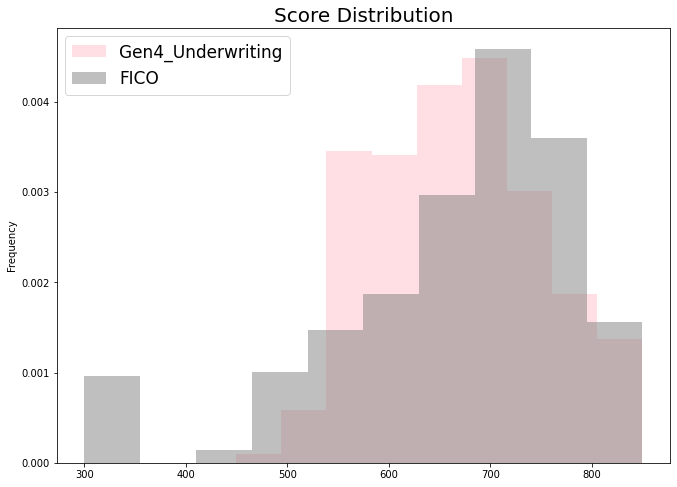

In [35]:
df_oot_['fico_adj'] = np.where(df_oot_.applicant_fico_score>850, 300, df_oot_.applicant_fico_score)
plt.figure(figsize=(11,8))
df_oot_['gen4_underwriting_score'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df_oot_['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

Text(0.5, 1.0, 'Score Distribution')

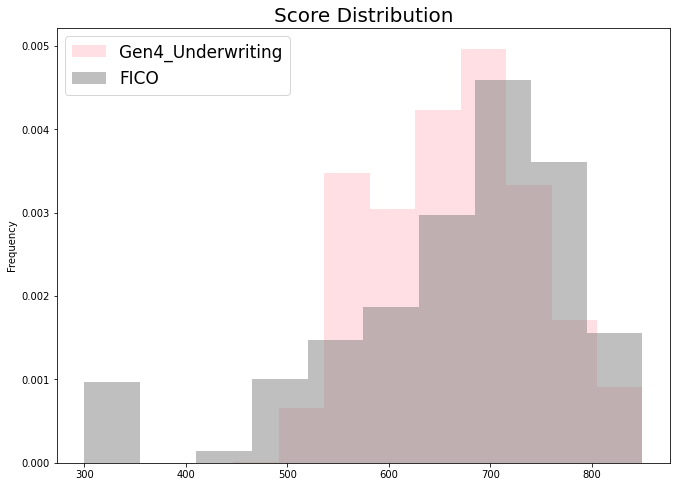

In [36]:
df_oot_['fico_adj'] = np.where(df_oot_.applicant_fico_score>850, 300, df_oot_.applicant_fico_score)
plt.figure(figsize=(11,8))
df_oot_['gen4_prescreen_score'].plot(kind='hist',density=True,alpha=0.5,label='Gen4_Underwriting',color='pink')
df_oot_['fico_adj'].plot(kind='hist',density=True,alpha=0.5,label='FICO',color='gray')
plt.legend(fontsize=17)
plt.title('Score Distribution',fontsize=20)

In [37]:
df_oot_[['id','applicant_type','date_start','gen4_prescreen_score','gen4_underwriting_score','gen4_underwriting_score_29']].head()

,id,applicant_type,date_start,gen4_prescreen_score,gen4_underwriting_score,gen4_underwriting_score_29
0,12486316,PRIMARY,2021-07-30,850.0,850.0,850.0
1,12598180,PRIMARY,2021-09-08,772.0,850.0,850.0
2,12498789,PRIMARY,2021-05-26,727.0,841.0,841.0
3,12601674,PRIMARY,2021-05-03,746.0,784.0,784.0
4,12661144,PRIMARY,2021-06-06,727.0,730.0,730.0


In [40]:
(df_oot_.date_start.min(), df_oot_.date_start.max())

(Timestamp('2021-04-01 00:00:00'), Timestamp('2022-01-31 00:00:00'))

In [42]:
# df_oot_[['id','applicant_type','date_start','gen4_prescreen_score','gen4_underwriting_score','gen4_underwriting_score_29']].to_parquet('s3://sofi-data-science/hpeng/pl-gen4/artifact/df_gen4_score_202104_202201_refit.parquet')